In [26]:
import pandas as pd
from datetime import timedelta

In [27]:
class DataAction:
  """
      The nuclear data-processing method.

  """

  def __init__(self):
    self.imp = None
    self.df = None
    self.chunk_size = 10000
    self.dfList = []


  def data_imp(self, file_name):
    # import from data location
    folder_path = '..\\data\\'
    file_path = folder_path + file_name
    self.imp = pd.read_csv(file_path, low_memory = False)


  def data_filter(self, df, keep_cols):
    # Process df inplace
    col_names = df.columns.tolist()
    for col in keep_cols:
        col_names.remove(col)
    
    df.drop(columns=col_names, inplace = True)
    df.dropna(inplace=True)
    df.rename(columns = {'cet_cest_timestamp':'date_time'}, inplace = True)
    self.df = df.set_index('date_time')


  def df_split(self, chunk_size):
    # splits the dataframe into smaller dataframes
    for i in range(0, self.df.shape[0], chunk_size):
        self.dfList.append(self.df[i:i+chunk_size])
    print('Number of data frame segments = ', len(self.dfList))


  def imp_procc(self, file_name, keep_cols):
    # easy import, data filter and split
    self.data_imp(file_name)
    self.data_filter(self.imp, keep_cols)
    self.df_split(self.chunk_size)
    print("dfList created successfully.")


  def parse_procc(self, df):
    # parse dates and convert index to time series
    # take the row difference and drop first NaN
    df.index = pd.to_datetime(df.index, exact=True, cache=True, format='%Y-%m-%d %H:%M:%S', dayfirst=True)
    ts = df.diff()
    ts.drop(str(ts.index[0]), inplace=True) # drop first NaN row
    return ts


  def unique_date(self, df): # helper function
    # find unique days in the time-series index df
    return df.index.map(lambda t: str(t.date())).unique().tolist()


  def get_night(self, ts, evening_date, start_time, end_time):
    # get the dates for loc slice
    start = evening_date + ' ' + start_time
    foo = pd.to_datetime(evening_date)
    bar = foo.replace(hour=int(end_time[0:2]), minute=int(end_time[3:5]), second=int(end_time[6:8])).strftime('%H:%M:%S')
    end = str(foo + timedelta(days=1))[:11] + bar

    # check for available date
    dates = self.unique_date(ts)
    if evening_date in dates:
        print("Date is accepted.")
        return ts.loc[start : end]
    else:
        print("Error: Evening_date is not part of the selected dataset!")
  

In [28]:
da = DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)

Number of data frame segments =  90
dfList created successfully.


Date is accepted.


<AxesSubplot:xlabel='date_time'>

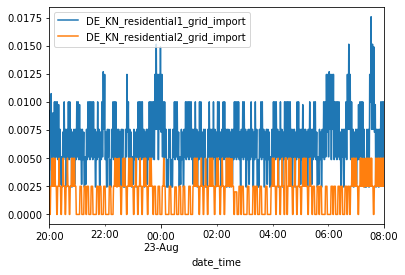

In [35]:
df = da.dfList[13]
ts = da.parse_procc(df)
night = da.get_night(ts, '2015-08-22', '20:00:00', '08:00:00')
night.plot()